# Case para *Data Science* Plannera

Neste *Jupyter Notebook* está a análise e tratamento dos dados cedidos como um *case* pela empresa Plannera. 

Fora as  bibliotecas padrões de *data science*, como pandas, numPy, scikit-learn e matplotlib, algumas bibliotecas extras foram utilizadas:

- seaborn, uma biblioteca para gerar gráficos. Para instalar, execute o comando 
> pip install seaborn

- scikit-lego, uma biblioteca que expande as funções da biblioteca scikit-learn. Para instalar, execute o comando
> pip install scikit-lego

Esse *notebook* importa suas funções de outros arquivos em Python. Para mais detalhes, dê uma olhada neles.

In [1]:
from geradorExcel import gerarExcel

from randomForest import gerarResultadoRandomForest, gerarResultadoZIRRandomForest
from linearRegression import gerarResultadoLinearRegression, gerarResultadoZIR_LR
from geradorGraficos import gerarGraficoMensal, gerarGraficoLinear, gerarGraficoMensalClusterEspecifico, gerarHistograma
from tratamentoDados import gerarDados, gerarMesTeste
from poisson import gerarResultadoPoisson, gerarResultadoZIRPoisson
from geradorMetricas import gerarMetricaGeral, gerarMetricasClusters

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

<Figure size 576x432 with 0 Axes>

Os dados históricos são lidos e tratados. Os dados sem o *target* estão em x. O *target* está em y. Os detalhes do tratamento dos dados estão em tratamentoDados.py.

In [2]:
X, y = gerarDados()

Para checar como é o formato do *target* que é buscado, é necessário analisar como é distribuido o *target* de cada elemento do conjunto de dados.

In [3]:
print(y.describe())

count    3360.000000
mean      632.178274
std      1080.704647
min         0.000000
25%         1.000000
50%       317.000000
75%       678.000000
max      7810.000000
Name: Remessas, dtype: float64


Pelo fato de ter elementos com o *target* de valor 0, isso pode prejudicar os modelos regressores que serão utilizados. 

Assimetria: 3.242776156654992
Curtose: 10.797080703001154


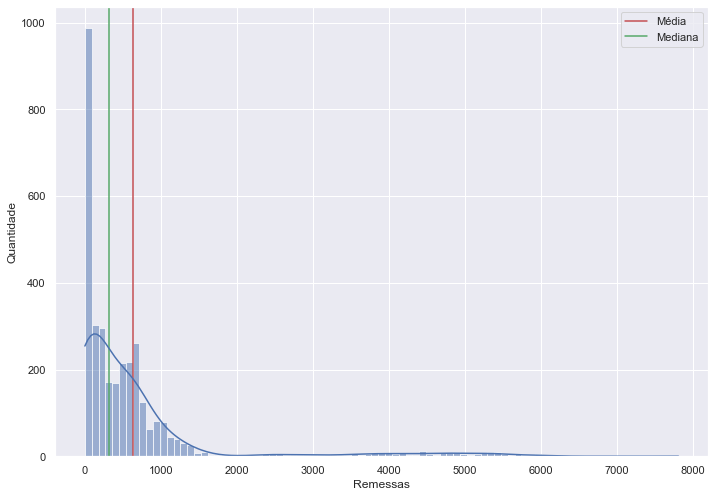

In [4]:
gerarHistograma(y)

Como o conjunto de dados não tem elementos negativos, a assimetria é positiva, indicando que existem mais elementos à direita do pico da função de distribuição. A curtose positiva indica uma curva leptocurtica, indicando que existem mais valores no *target* que fogem da média do que valores que convirjam [para a média].

### O problema: o modelo é inflado por zeros

Utilizando o histograma, é fácil de perceber que existem muitos valores 0 no *target*. Isso prejudicará os modelos na hora da predição. Quando um conjunto de dados tem uma grande quantidade de valores no *target* como 0, isso pode atrapalhar o treinamento de um modelo regressor. Esses problemas são chamados de *zero-inflated*, ou inflados por zeros.

Uma solução para esse tipo de distribuição no conjunto de dados: utilizar um modelo em duas partes, que será explicado futuramente.

### Outra maneira de ver o conjunto de dados

Outro jeito de visualizar o *target* é comparar o mesmo com outra *feature* que é diretamente proporcional ao mesmo: Volume. Cria-se, então, o gráfico "Remessas x Volume".

Text(0, 0.5, 'Remessas')

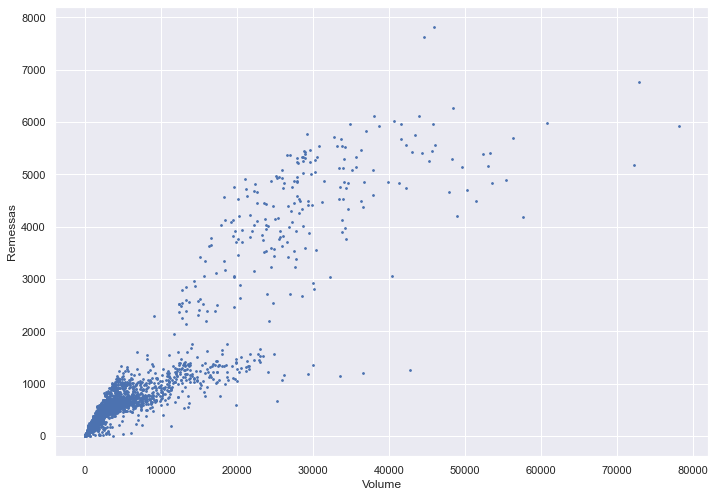

In [5]:
plt.clf()

plt.scatter(X['Volume'], y, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Realmente a relação entre essas duas *features* é mais ou menos diretamente proporcional. Com essa informação, pode-se concluir que a predição de um mês será do mesmo modelo: na maioria das vezes, quanto maior a *feature* volume, maior o *target* Remessas.

## Separando os dados em treinamento e teste

Para ter uma métrica de cada modelo e o quão preciso é o mesmo, é utilizado o próprio conjunto de dados com o *target* que temos. É, então, selecionado um mês disponível no conjunto de dados para ser separado como teste. O resto dos meses serão utilizados para treinamento de cada modelo preditivo.

In [6]:
mes = 3
ano = 2020

Para fins de teste, foi escolhido o mês de Março de 2020. Qualquer outro mês existente no conjunto de dados "Dados Históricos" pode ser escolhido. 

In [7]:
X_treino, X_teste, y_treino, y_teste = gerarMesTeste(X, y, mes, 2020)

Text(0, 0.5, 'Remessas')

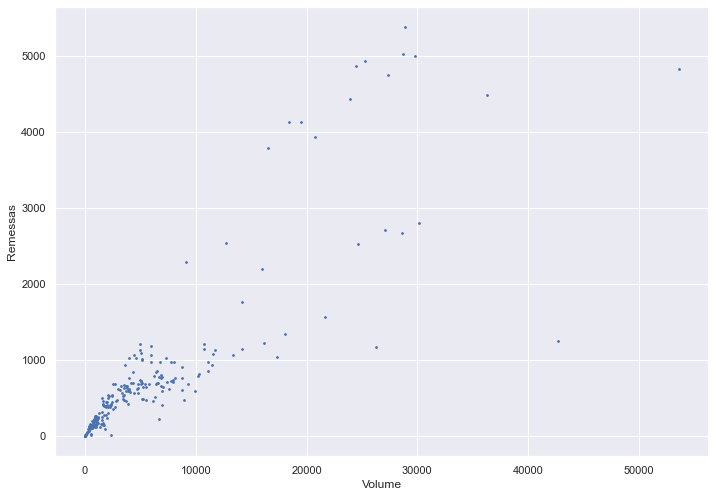

In [8]:
plt.clf()

plt.scatter(X_teste['Volume'], y_teste, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

## Os modelos

### *Random Forest* convencional

Um dos modelos escolhidos para esse *case* foi o *Random Forest*. O *Random Forest* é um modelo pretidivo do tipo *ensemble*, ou seja, é um conjunto de outros modelos preditivos, nesse caso, a árvore de decisão. Esse modelo pode ser usado tanto para problemas de classificação quanto para regressão. Esse modelo preditor consegue lidar bem com *targets* com um excesso de valores 0, então foi uma opção na hora de escolher um modelo para o *case*.

In [9]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)

Após a criação do modelo *Random Forest* e seu treinamento, o resultado é calculado. Após isso, é comparado o mesmo com o valor real do mês, dado que temos esse valor no conjunto de dados.

Text(0, 0.5, 'Remessas previstas')

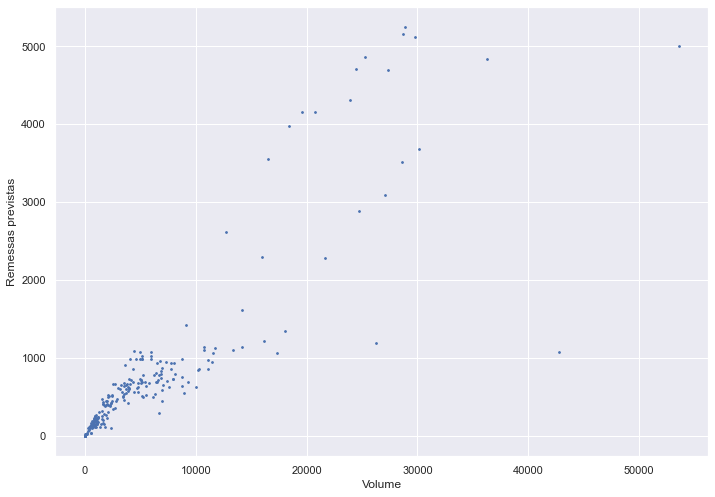

In [10]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoRF, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas previstas")

Assimetria: 3.1369350529628623
Curtose: 10.018464629733204


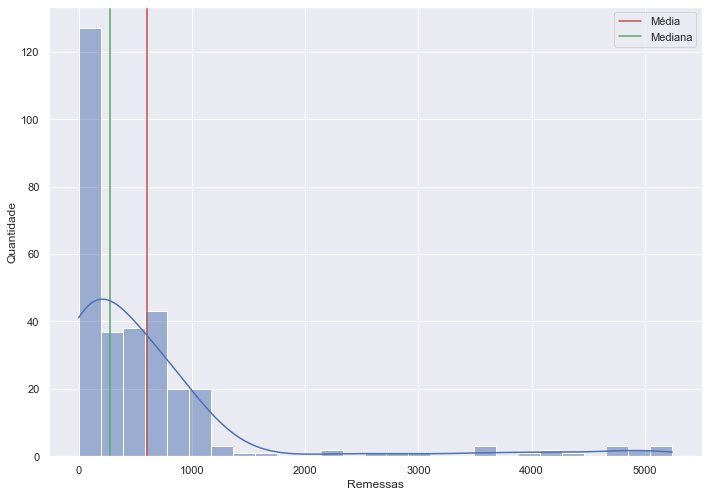

In [11]:
gerarHistograma(resultadoRF)

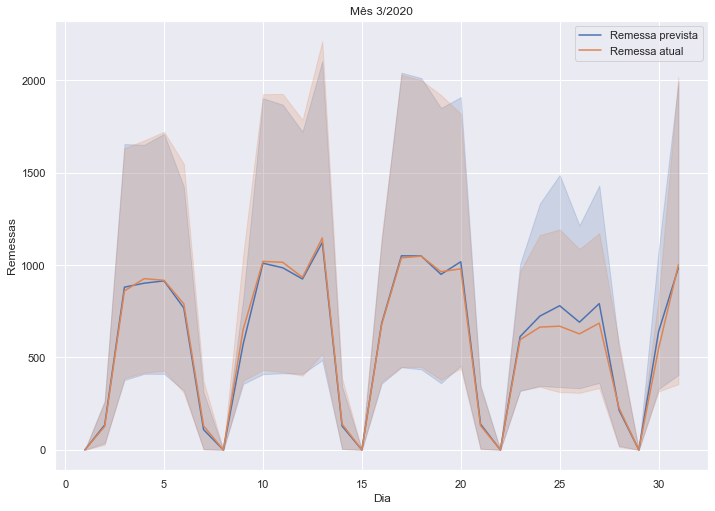

In [12]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoRF, comecoMes = 0)

As linhas representam os valores médios de cada *Cluster*. As áreas em volta das linhas são os valores reais e sua flutuação. As linhas e as áreas estão bem próximas uma das outras, indicando que o modelo criado parece estar bom. Mas, o quão bom está?

In [13]:
gerarMetricaGeral(y_teste, resultadoRF)

Mean Squared Error: 11937.45388032258
Root Mean Squared Error: 109.25865585994815
Mean Absolute Error: 32.324612903225805



Dado que cada métrica pode variar de 0 até o infinito, parece que os resultados não são os melhores, apesar do gráfico nos mostrar que o resultado está bem próximo do valor original. Que tal ver os gráficos e as medidas isoladas de cada *Cluster*? Talvez um ou mais sejam um *outlier*, ou seja, algo fora do padrão, que pode ir contra ao que o modelo aprendeu. 

<Figure size 842.4x595.44 with 0 Axes>

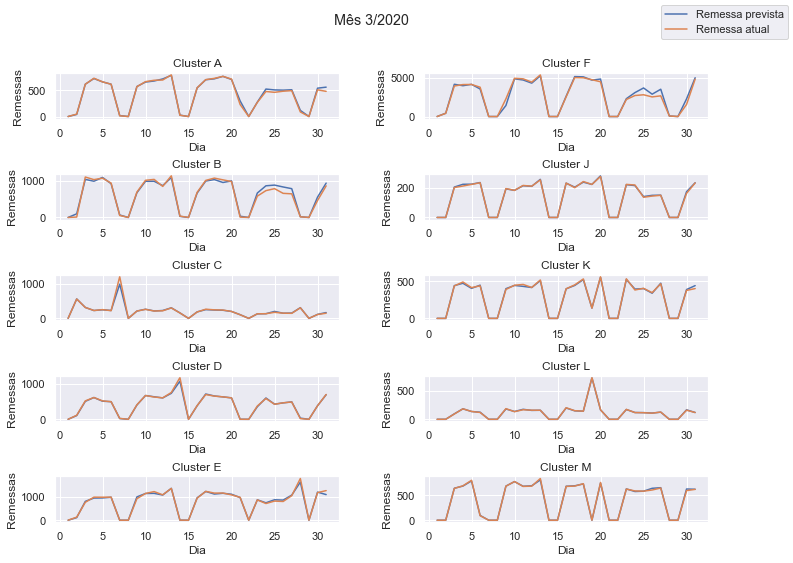

In [14]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoRF, comecoMes = 0)

Só pelo gráfico, dá para ver que o modelo é até bem preciso no maior dos casos. Os *Clusters* que tem mais diferença entre o valor real e o predito são o B e o F. 

In [15]:
gerarMetricasClusters(X_teste, y_teste, resultadoRF)

No Cluster A
Mean Squared Error: 600.0209387096772
Root Mean Squared Error: 24.49532483372444
Mean Absolute Error: 14.02548387096773

No Cluster B
Mean Squared Error: 4069.5005290322583
Root Mean Squared Error: 63.79263694998239
Mean Absolute Error: 45.09806451612903

No Cluster C
Mean Squared Error: 1569.9753580645163
Root Mean Squared Error: 39.62291455792363
Mean Absolute Error: 10.987419354838707

No Cluster D
Mean Squared Error: 406.3595774193554
Root Mean Squared Error: 20.15836246869659
Mean Absolute Error: 8.466774193548385

No Cluster E
Mean Squared Error: 2529.3210870967746
Root Mean Squared Error: 50.292356149784574
Mean Absolute Error: 29.51193548387098

No Cluster F
Mean Squared Error: 109942.37192258063
Root Mean Squared Error: 331.57559005840676
Mean Absolute Error: 198.70580645161286

No Cluster J
Mean Squared Error: 13.410887096774179
Root Mean Squared Error: 3.6620878057160478
Mean Absolute Error: 2.2041935483870954

No Cluster K
Mean Squared Error: 117.14516451612899

Utilizando as métricas, é confirmado as suspeitas: enquanto a média do erro absoluto varia entre 2 e 30 nos outros *Clusters*, o B e o F têm a média de erro absoluto de 44 e 214, respectivamente.

O resultado será salvo como um arquivo em Excel.

In [16]:
gerarExcel(resultadoRF, X_teste, mes = mes, ano = ano, nome = 'RandomForest', train = True)

### *Random Forest* como um regressor inflado com zeros (*Zero-Inflated Regressor*)

Para resolver o problema do *target* ser inflado por zeros e possivelmente melhorar os resultados do *Random Forest*, a biblioteca scikit-lego tem a implementação de um *Zero-Inflated Regressor*, ou ZIR. 

A grande diferença desse modelo para o *Random Forest* convencional é que, durante o treino, este roda um classificador para treinar qual valor no *target* é 0 e qual não é. Após isso, os valores que são diferentes de 0 são utilizados para treinar outro modelo, dessa vez, um regressor. Como o *Random Forest* funciona para ambos os problemas, o ZIR utilizado nesse conjunto de dados utilizará o *Random Forest* tanto para a parte de classificação quanto para a parte de regressão.

In [17]:
resultadoZIR = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

Text(0, 0.5, 'Remessas')

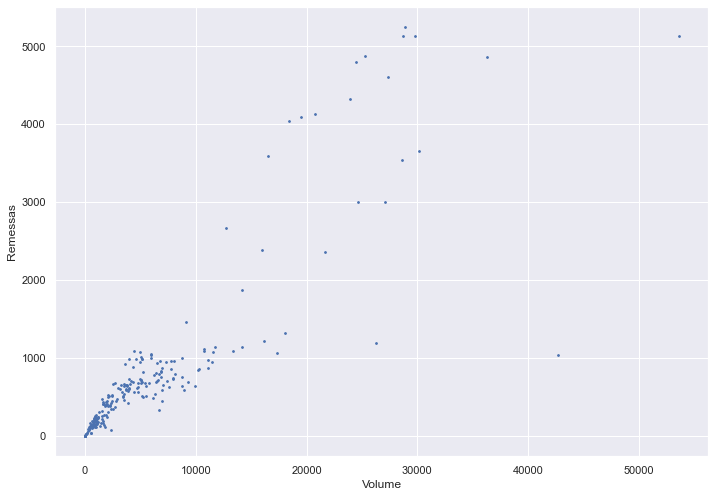

In [18]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoZIR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 3.1258552082386597
Curtose: 9.939639363150466


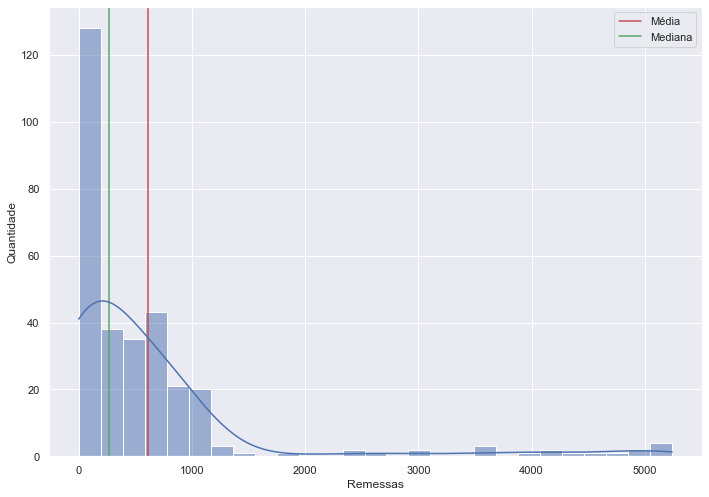

In [19]:
gerarHistograma(resultadoZIR)

Então, o gráfico é gerado com o resultado.

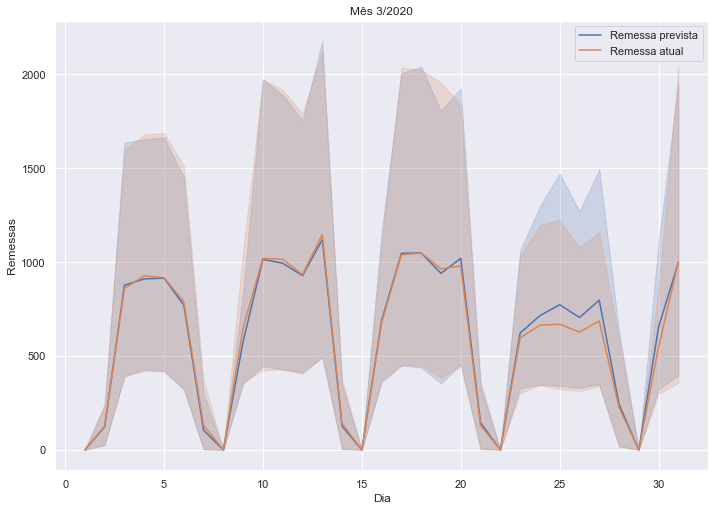

In [20]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoZIR, comecoMes = 0)

Como antes, será exibido as suas métricas avaliativas.

In [21]:
gerarMetricaGeral(y_teste, resultadoZIR)

Mean Squared Error: 12729.968591612906
Root Mean Squared Error: 112.82716247257531
Mean Absolute Error: 34.18270967741935



Os resultados das métricas são melhores que o *Random Forest* convencional. Após isso, tem o gráfico comparativo de cada *Cluster* e suas métricas.

<Figure size 842.4x595.44 with 0 Axes>

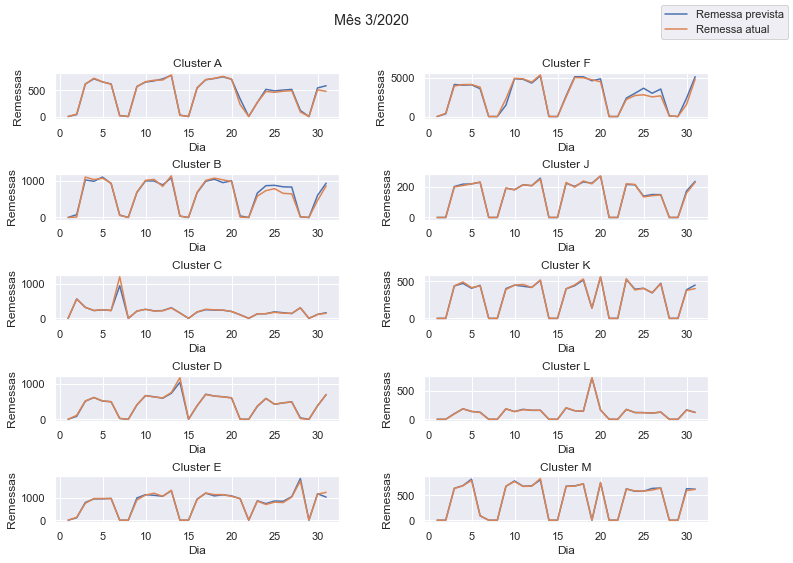

In [22]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoZIR, comecoMes = 0)

Como antes, os *Clusters* B e F apresentam a maior diferença entre predição e valor real. Mas, os *Clusters* individuais tiveram melhora em relação ao *Random Forest* convencional?

In [23]:
gerarMetricasClusters(X_teste, y_teste, resultadoZIR)

No Cluster A
Mean Squared Error: 939.4182322580647
Root Mean Squared Error: 30.64993037933471
Mean Absolute Error: 16.11612903225807

No Cluster B
Mean Squared Error: 4894.970570967742
Root Mean Squared Error: 69.96406628382702
Mean Absolute Error: 47.77322580645162

No Cluster C
Mean Squared Error: 2273.152058064516
Root Mean Squared Error: 47.67758444032705
Mean Absolute Error: 12.629677419354834

No Cluster D
Mean Squared Error: 640.57206451613
Root Mean Squared Error: 25.309525173660013
Mean Absolute Error: 9.494193548387104

No Cluster E
Mean Squared Error: 2894.810483870967
Root Mean Squared Error: 53.80344304847941
Mean Absolute Error: 30.610967741935482

No Cluster F
Mean Squared Error: 115354.72133870969
Root Mean Squared Error: 339.6391045487985
Mean Absolute Error: 207.91645161290324

No Cluster J
Mean Squared Error: 18.248867741935463
Root Mean Squared Error: 4.271869349820458
Mean Absolute Error: 2.78548387096774

No Cluster K
Mean Squared Error: 134.67080967741944
Root Me

A melhora não foi muito significativa, mas foi, mesmo assim, uma melhora.

De novo, os valores foram salvos em um arquivo Excel.

In [24]:
gerarExcel(resultadoZIR, X_teste, mes = mes, ano = ano, nome = 'ZIR_RandomForest', train = True)

### Regressão linear padrão

A Regressão Linear é um algoritmo que treina a partir de *feature*(s) do conjunto de dados e traça uma linha no gráfico que representa a correlação entre a(s) *feature*(s) e o *target*. A linha é formada a partir desta fórmula:

> y = $\theta$ * x + b

sendo:

- $\theta$ o peso da *feature*, que representa o impacto que a mesma tem quando treinando o modelo.

- b o interceptor, ou, o termo de viés, que representa a tendência do resultado da regressão de se deslocar de maneira consistente, a partir da origem, quando perto de unidades b.

In [25]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Após criar e treinar o modelo de regressão linear, é gerado o resultado em um gráfico. 

Text(0, 0.5, 'Remessas')

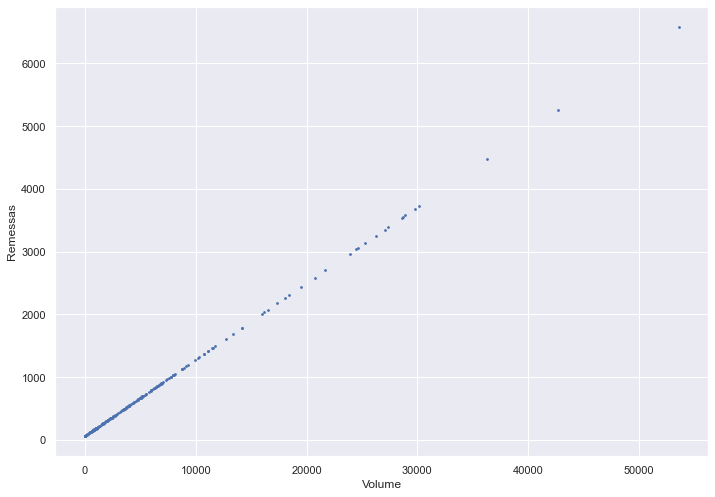

In [26]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 3.0147852174059073
Curtose: 11.189047455926806


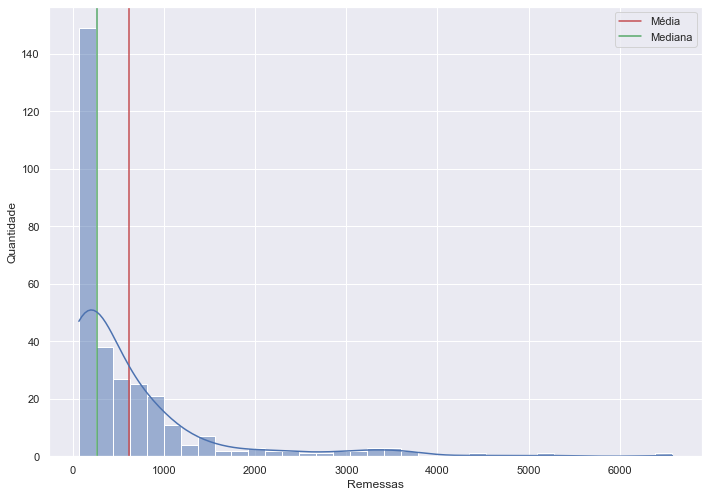

In [27]:
gerarHistograma(resultadoLR)

Como esperado, o resultado da regressão linear gerou pontos muito mais ordenados que as versões de *Random Forest*.

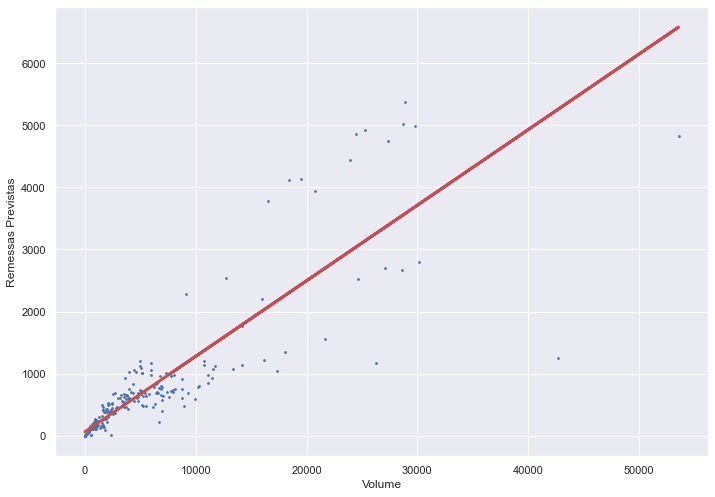

In [28]:
gerarGraficoLinear(X_teste, y_teste, resultadoLR)

E esse é o gráfico que foi gerado, comparando o valor real do *target* com a linha gerada a partir da Regressão Linear.

Comparando esse gráfico e o resultado com os gráficos e os resultados, A regressão linear não parece ser melhor que os modelos já vistos.

O gráfico que representa a previsão do mês feita pelo modelo e as medidas avaliativas da previsão são exibidos a seguir.

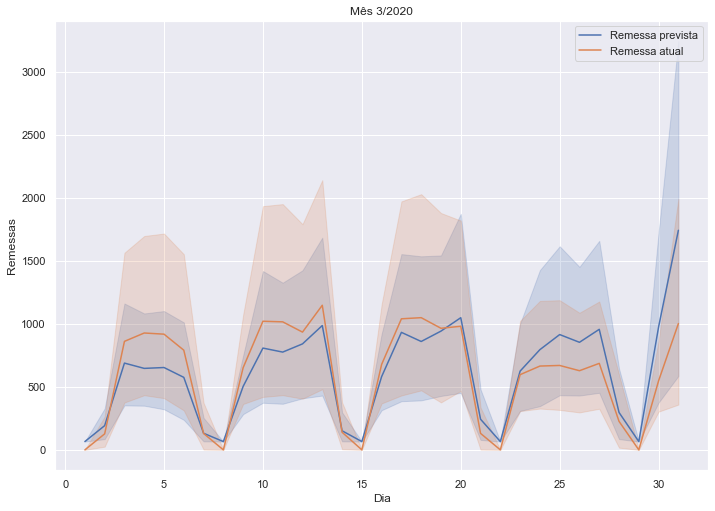

In [29]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0)

In [30]:
gerarMetricaGeral(y_teste, resultadoLR)

Mean Squared Error: 227058.3625372308
Root Mean Squared Error: 476.50641395182794
Mean Absolute Error: 223.55294967485082



Uma medida extra que pode ser utilizada para avaliar o quão bom é esse modelo de Regressão Linear é a medida R^2. Essa medida revela quanto a variação do resultado pode ser explicada em relação à *feature* escolhida para treinar o modelo. Um valor perfeito é 1, podendo atingir valores negativos (pois o modelo pode ser arbitrariamente ruim em prever valores após treinado). Quando o modelo tem R^2 = 0, ele está acertando todas as predições.

In [31]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7581803752241201


<Figure size 842.4x595.44 with 0 Axes>

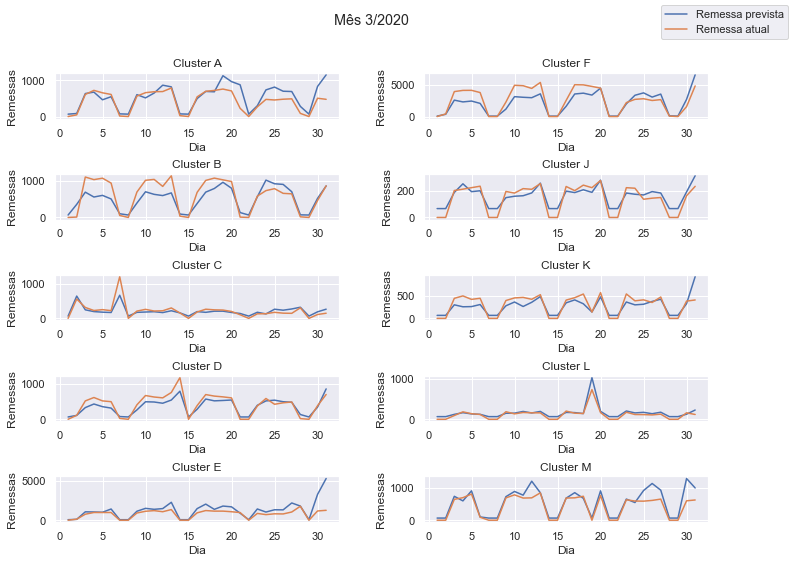

In [32]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0)

In [33]:
gerarMetricasClusters(X_teste, y_teste, resultadoLR)

No Cluster A
Mean Squared Error: 53155.87166948258
Root Mean Squared Error: 230.55557175978763
Mean Absolute Error: 157.11299651781215

No Cluster B
Mean Squared Error: 66316.78595829784
Root Mean Squared Error: 257.52045735882393
Mean Absolute Error: 206.5000956412467

No Cluster C
Mean Squared Error: 13391.048282747539
Root Mean Squared Error: 115.7196970387822
Mean Absolute Error: 72.56928383822995

No Cluster D
Mean Squared Error: 18192.501619734663
Root Mean Squared Error: 134.87958192304225
Mean Absolute Error: 111.54846513909526

No Cluster E
Mean Squared Error: 839211.2198300558
Root Mean Squared Error: 916.0847230633507
Mean Absolute Error: 499.1536507980869

No Cluster F
Mean Squared Error: 1206167.7709622758
Root Mean Squared Error: 1098.2566962974893
Mean Absolute Error: 848.4738645715629

No Cluster J
Mean Squared Error: 2327.5803829210813
Root Mean Squared Error: 48.245003709411
Mean Absolute Error: 43.696515890936816

No Cluster K
Mean Squared Error: 19539.282912409166
R

Como esperado, a Regressão Linear tem uma média de erro muito maior que os modelos baseados em *Random Forest*. 

Um jeito de aprimorar a Regressão Linear é utilizar mais do que uma *feature* para treinar o modelo. 

In [34]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 8)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana']


Assimetria: 2.9084409476132405
Curtose: 10.468353788619677


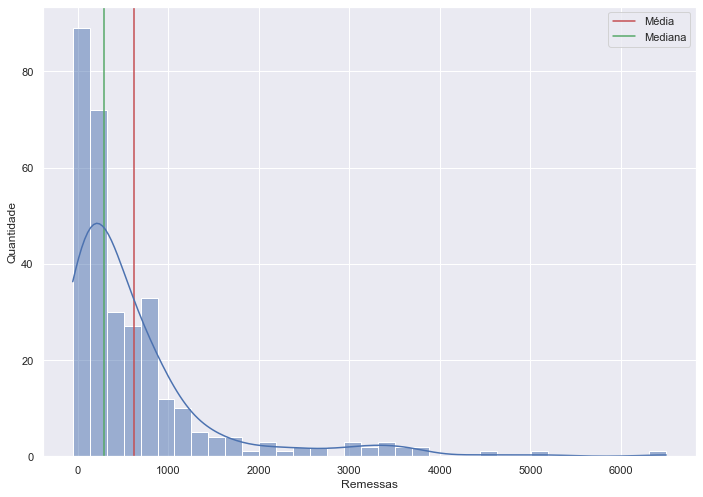

In [35]:
gerarHistograma(resultadoLR)

Text(0, 0.5, 'Remessas')

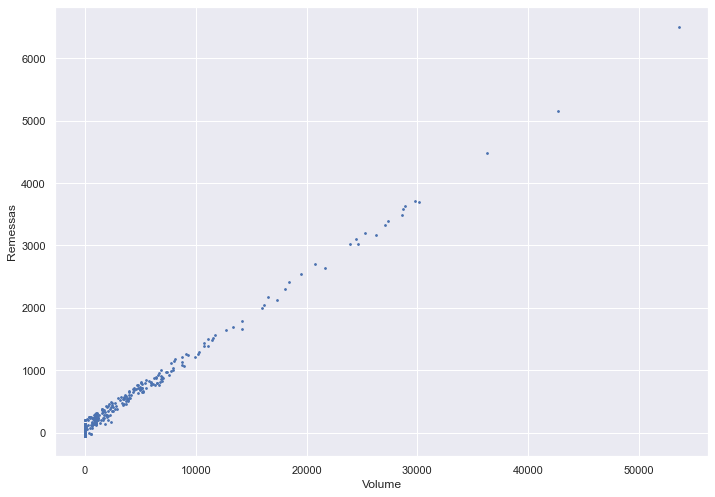

In [36]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

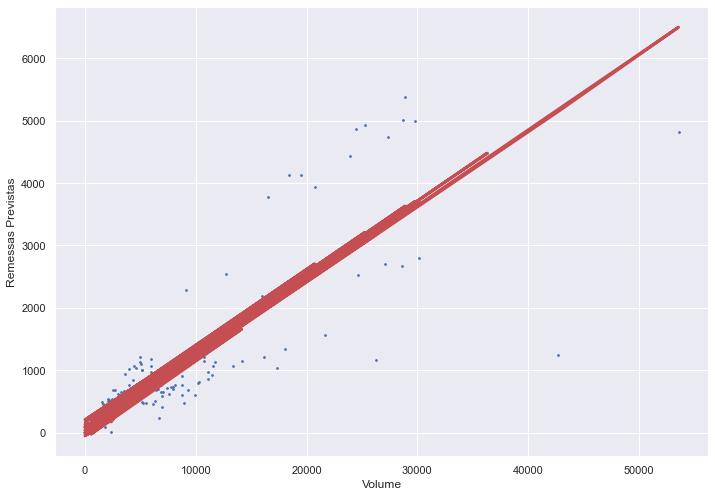

In [37]:
gerarGraficoLinear(X_teste, y_teste, resultadoLR)

A linha que intercepta os pontos passa a ser uma função mais complexa que somente uma função de 1º grau. Porém, a complexidade torna ela mais próxima do que os valores reais são, melhorando, assim, a predição do modelo.

In [38]:
gerarMetricaGeral(y_teste, resultadoLR)

Mean Squared Error: 209445.00857526233
Root Mean Squared Error: 457.651623590764
Mean Absolute Error: 214.25583213612583



In [39]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7769387886933865


Como o modelo se comportará, então, se usarmos todas as *features*?

In [40]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 18)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana', 'Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E', 'Cluster_F', 'Cluster_J', 'Cluster_K', 'Cluster_L', 'Cluster_M']


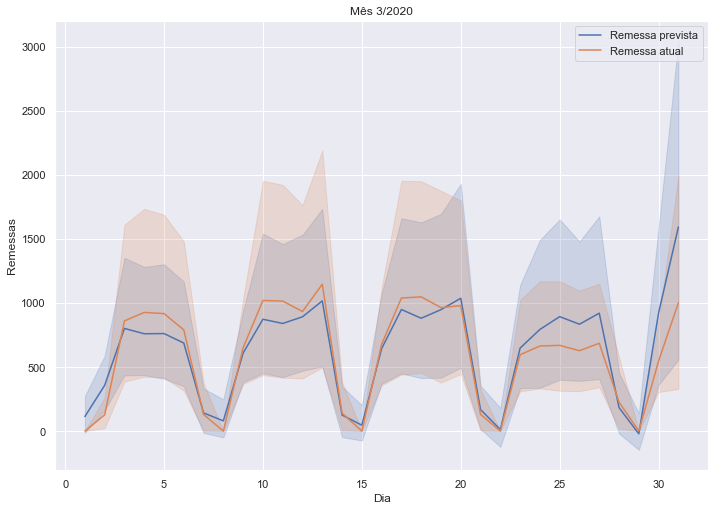

In [41]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0)

<Figure size 842.4x595.44 with 0 Axes>

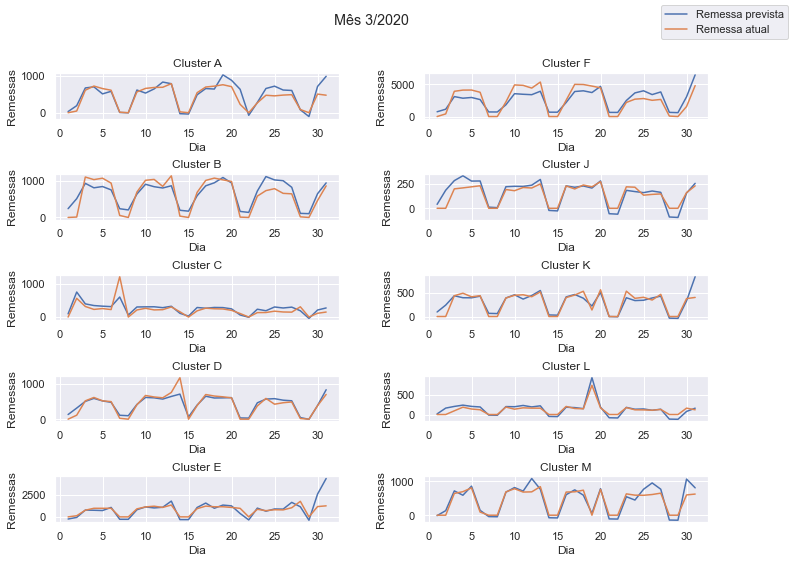

In [42]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoLR, comecoMes = 0)

Parece um pouco melhor em relação a antes, mas não muito promissor... A seguir, as métricas:

In [43]:
gerarMetricasClusters(X_teste, y_teste, resultadoLR)

No Cluster A
Mean Squared Error: 26746.61820478904
Root Mean Squared Error: 163.54393356156334
Mean Absolute Error: 113.75913069029657

No Cluster B
Mean Squared Error: 40279.193265632755
Root Mean Squared Error: 200.6967694449334
Mean Absolute Error: 174.80694238118446

No Cluster C
Mean Squared Error: 19362.95868557204
Root Mean Squared Error: 139.15084866996693
Mean Absolute Error: 93.26301932433665

No Cluster D
Mean Squared Error: 12374.56954080822
Root Mean Squared Error: 111.24104251942364
Mean Absolute Error: 67.81573708953088

No Cluster E
Mean Squared Error: 450448.29671734164
Root Mean Squared Error: 671.1544507170772
Mean Absolute Error: 366.14590028078004

No Cluster F
Mean Squared Error: 960703.9459007094
Root Mean Squared Error: 980.1550621716491
Mean Absolute Error: 909.8082478325636

No Cluster J
Mean Squared Error: 3328.211581614217
Root Mean Squared Error: 57.69065419644864
Mean Absolute Error: 42.33296273284565

No Cluster K
Mean Squared Error: 11452.301571025366
Ro

In [44]:
r2LR = r2_score(y_teste, resultadoLR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.8344814547341125


Um resultado mais parecido com os obtidos pelo *Random Forest* e sua versão ZIR.

In [45]:
gerarExcel(resultadoLR, X_teste, mes = mes, ano = ano, nome = 'LinearRegression', train = True)

### Regressão Linear com *Zero-Inflated Regressor*

Como visto anteriormente, a Regressão Linear não teve um resultado bom com o conjunto de dados. O motivo: os valores 0 atrapalha a predição do modelo, resultado em valores negativos (coisa que não deveria existir em uma expectativa de quantidade de remessas de produtos) quando deveria ser 0, e, quando não é 0, os valores gerados não são os mais precisos. 

Para resolver isso, é utilizado um modelo inflado por zero, similar ao que foi utilizado com o modelo de *Random Forest*: um classificador (nesse caso, o *Random Forest*) para prever quando o valor é 0 e quando não é, e um regressor (a Regressão Linear) para predizer os valores.

In [46]:
resultado_ZIR_LR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Text(0, 0.5, 'Remessas')

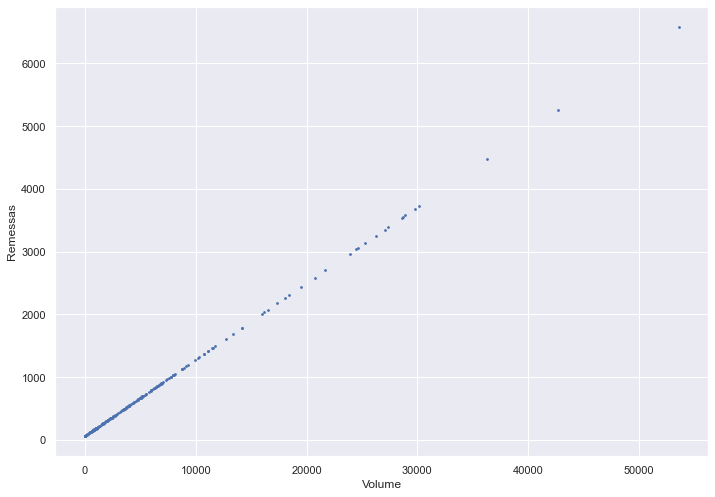

In [47]:
plt.clf()

plt.scatter(X_teste['Volume'], resultado_ZIR_LR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Como esperado, os valores formam uma linha reta no gráfico "Volume x Remessas".

Assimetria: 3.0147852174059073
Curtose: 11.189047455926806


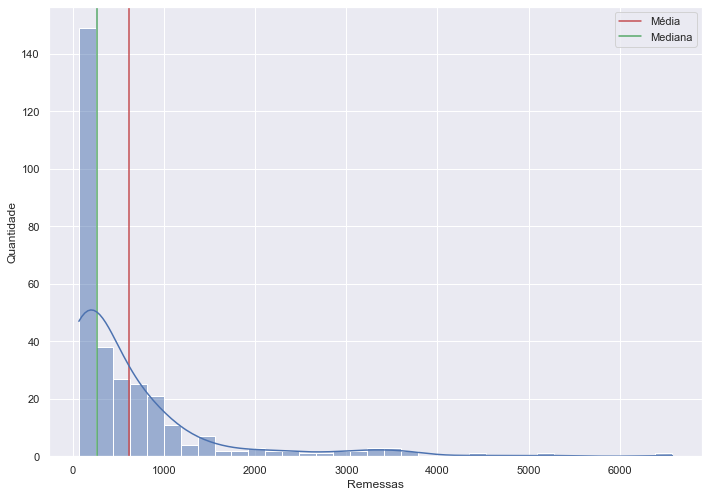

In [48]:
gerarHistograma(resultado_ZIR_LR)

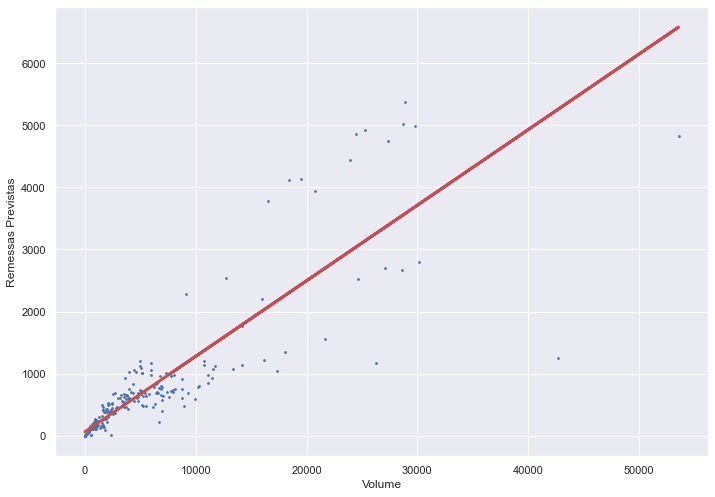

In [49]:
gerarGraficoLinear(X_teste, y_teste, resultado_ZIR_LR)

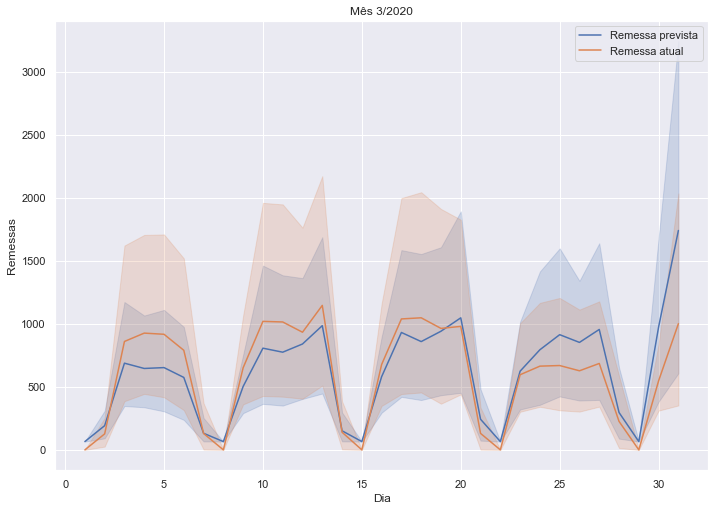

In [50]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultado_ZIR_LR, comecoMes = 0)

In [51]:
gerarMetricaGeral(y_teste, resultado_ZIR_LR)

Mean Squared Error: 227058.3625372308
Root Mean Squared Error: 476.50641395182794
Mean Absolute Error: 223.55294967485082



In [52]:
r2LR = r2_score(y_teste, resultado_ZIR_LR)

print('R^2 Score: {}'.format(r2LR))

R^2 Score: 0.7581803752241201


<Figure size 842.4x595.44 with 0 Axes>

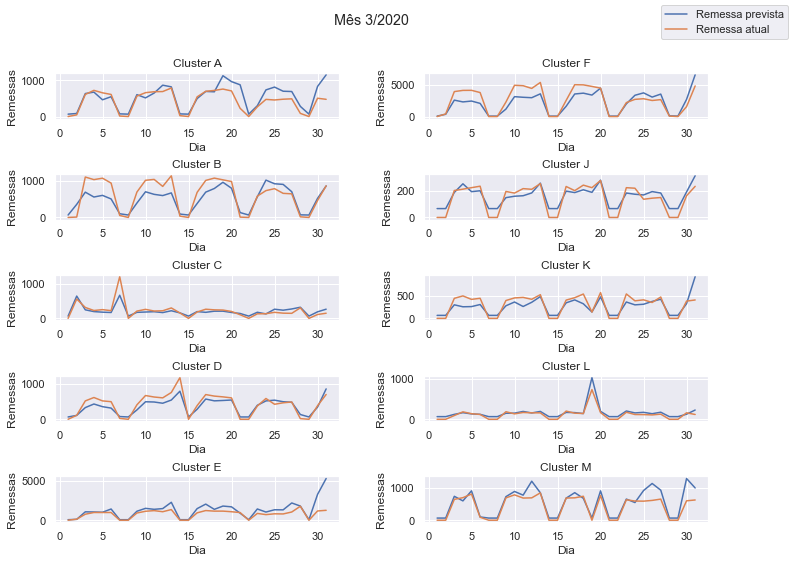

In [53]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultado_ZIR_LR, comecoMes = 0)

In [49]:
gerarMetricasClusters(X_teste, y_teste, resultado_ZIR_LR)

No Cluster A
Mean Squared Error: 53155.87166948258
Root Mean Squared Error: 230.55557175978763
Mean Absolute Error: 157.11299651781215

No Cluster B
Mean Squared Error: 66316.78595829784
Root Mean Squared Error: 257.52045735882393
Mean Absolute Error: 206.5000956412467

No Cluster C
Mean Squared Error: 13391.048282747539
Root Mean Squared Error: 115.7196970387822
Mean Absolute Error: 72.56928383822995

No Cluster D
Mean Squared Error: 18192.501619734663
Root Mean Squared Error: 134.87958192304225
Mean Absolute Error: 111.54846513909526

No Cluster E
Mean Squared Error: 839211.2198300558
Root Mean Squared Error: 916.0847230633507
Mean Absolute Error: 499.1536507980869

No Cluster F
Mean Squared Error: 1206167.7709622758
Root Mean Squared Error: 1098.2566962974893
Mean Absolute Error: 848.4738645715629

No Cluster J
Mean Squared Error: 2327.5803829210813
Root Mean Squared Error: 48.245003709411
Mean Absolute Error: 43.696515890936816

No Cluster K
Mean Squared Error: 19539.282912409166
R

### Distribuição de Poisson

Na estatística, a distribuição de Poisson descreve resultados de experiências nos quais contamos acontecimentos que ocorrem aleatoriamente mas a uma taxa média definida. Essa distribuição pode ser utilizada para prever diversos acontecimentos: nascimento de bebês por mês em um hospital, o decaimento radioativo de um elemento químico, ou até gols de certo time em um jogo. A fórmula probabilística que representa a distribuição dos valores de um determinado evento é:

> P(X = x) = $\frac{\lambda^{k} * e^{\lambda} } {k!}$

Onde:

- $\lambda$ representa um número real correspondente ao número de ocorrências de um valor em um determinado intervalo de tempo;
- k representa a quantidade de vezes que um evento ocorre em um intervalo de tempo;
- e é o número de Euler.

Com essa fórmula e com o conjunto de dados, é possível treinar um modelo para prever, em um período de tempo, um valor para cada *cluster*, a cada dia. 

In [50]:
resultadoPoisson = gerarResultadoPoisson(X_treino, X_teste, y_treino)

Após o treinamento, gera-se um gráfico do estilo "Volume x Remessas", a *feature* e o *target* ediretamente proporcionais.

Text(0, 0.5, 'Remessas')

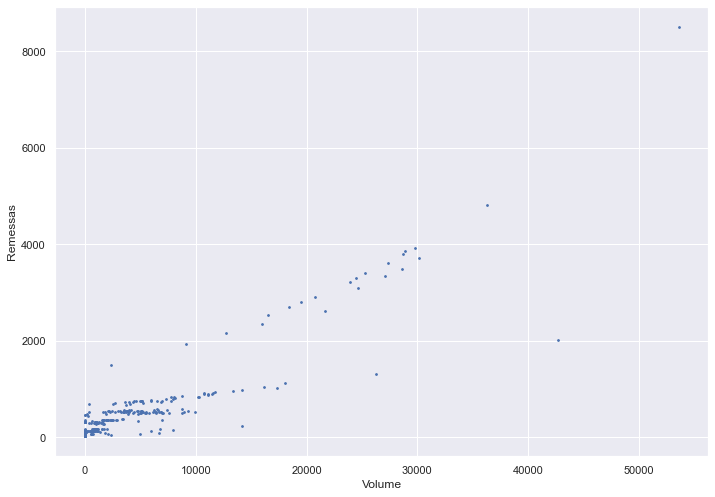

In [51]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoPoisson, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 4.231141450912984
Curtose: 24.435344839379972


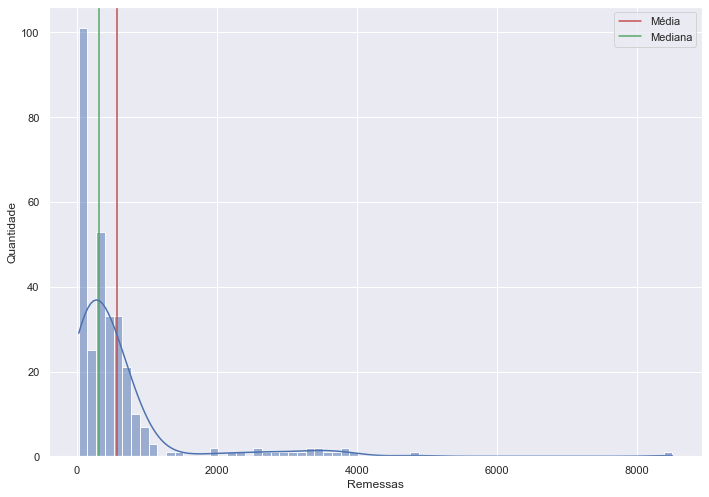

In [52]:
gerarHistograma(resultadoPoisson)

Parece bom... Mas, o quão bom?

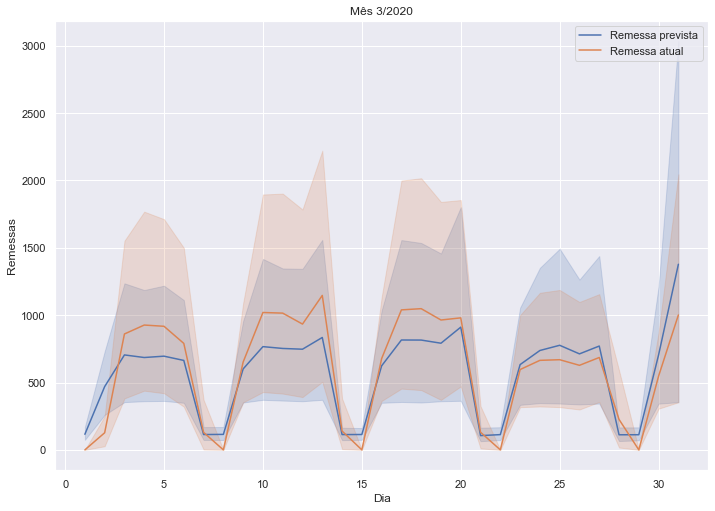

In [53]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoPoisson, comecoMes = 0)

<Figure size 842.4x595.44 with 0 Axes>

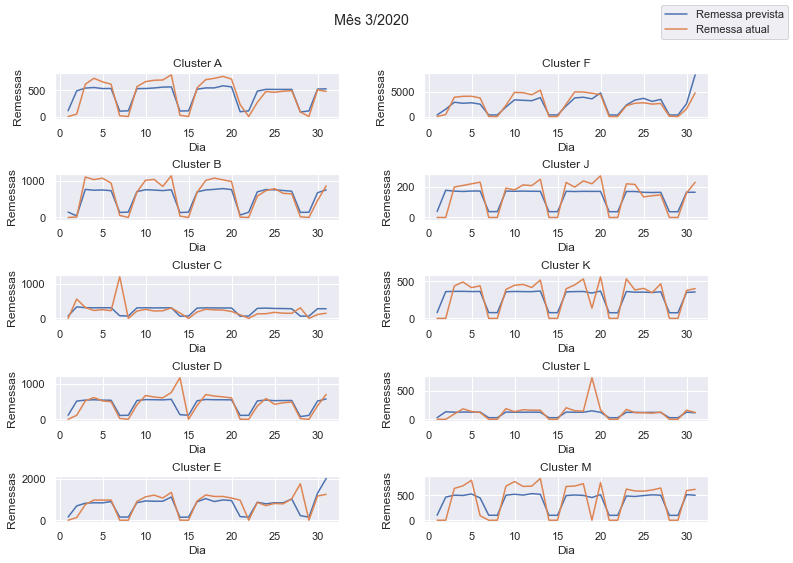

In [54]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoPoisson, comecoMes = 0)

O gráfico mensal parece se aproximar do valor real, mas será que esse modelo estatístico se saiu melhor que os outros? As métricas podem confirmar ou negar.

In [55]:
gerarMetricaGeral(y_teste, resultadoPoisson)

Mean Squared Error: 160352.36462725562
Root Mean Squared Error: 400.4402135491085
Mean Absolute Error: 200.15394842712965



In [56]:
gerarMetricasClusters(X_teste, y_teste, resultadoPoisson)

No Cluster A
Mean Squared Error: 19890.20317996019
Root Mean Squared Error: 141.03263161396438
Mean Absolute Error: 113.76386856087413

No Cluster B
Mean Squared Error: 36464.77752618965
Root Mean Squared Error: 190.9575280689129
Mean Absolute Error: 160.4982399227724

No Cluster C
Mean Squared Error: 52834.404216257935
Root Mean Squared Error: 229.85735623698872
Mean Absolute Error: 128.08755026958184

No Cluster D
Mean Squared Error: 50280.550530321496
Root Mean Squared Error: 224.2332502781902
Mean Absolute Error: 133.9197966055647

No Cluster E
Mean Squared Error: 143935.95385528146
Root Mean Squared Error: 379.3889216296141
Mean Absolute Error: 229.17407666695956

No Cluster F
Mean Squared Error: 1229132.1652462848
Root Mean Squared Error: 1108.6623314816304
Mean Absolute Error: 869.4694376456348

No Cluster J
Mean Squared Error: 3070.715068463653
Root Mean Squared Error: 55.41403313659504
Mean Absolute Error: 45.8502434531958

No Cluster K
Mean Squared Error: 13639.588250060455
R

Os resultados da distribuição de Poisson não foram muito diferentes obtidos pela Regressão Linear, caindo no mesmo problema: o algoritmo não sabe identificar os zeros e lidar com eles. 

In [57]:
gerarExcel(resultadoPoisson, X_teste, mes = mes, ano = ano, nome = 'Poisson', train = True)

### Distribuição de Poisson com *Zero-Inflated Regressor*

Então, para melhorar o modelo estatístico, o regressor para conjuntos de dados inflados por zeros pode resolver. Como classificador, esse modelo utiliza o *Random Forest* e, para o regressor, a Distribuição de Poisson padrão.

In [58]:
resultadoZIRPoisson = gerarResultadoZIRPoisson(X_treino, X_teste, y_treino)

Text(0, 0.5, 'Remessas')

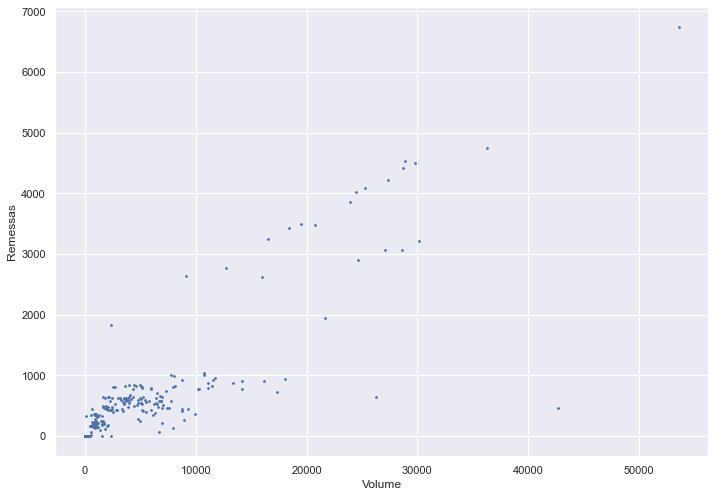

In [59]:
plt.clf()

plt.scatter(X_teste['Volume'], resultadoZIRPoisson, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 3.3941483697646215
Curtose: 12.743686751013094


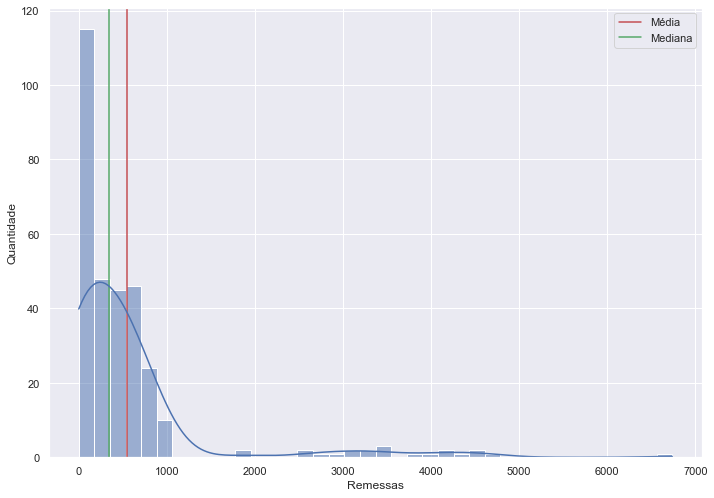

In [60]:
gerarHistograma(resultadoZIRPoisson)

Os valores parecem um pouco melhor distribuidos... E a previsão?

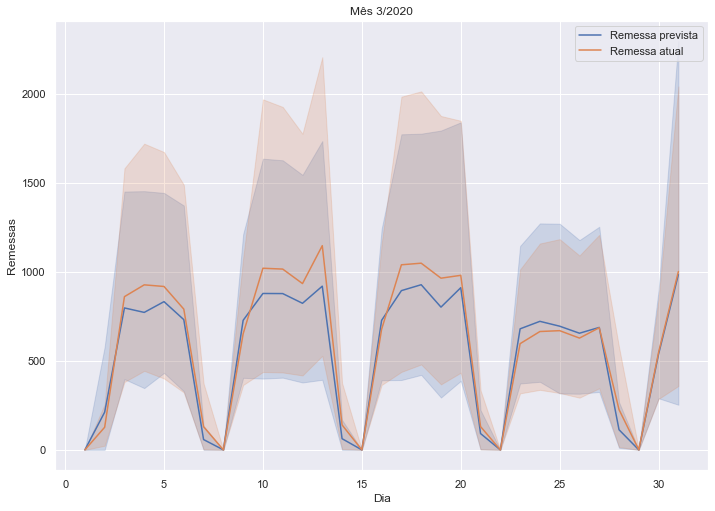

In [61]:
gerarGraficoMensal(X_treino, X_teste, y_teste, resultadoZIRPoisson, comecoMes = 0)

<Figure size 842.4x595.44 with 0 Axes>

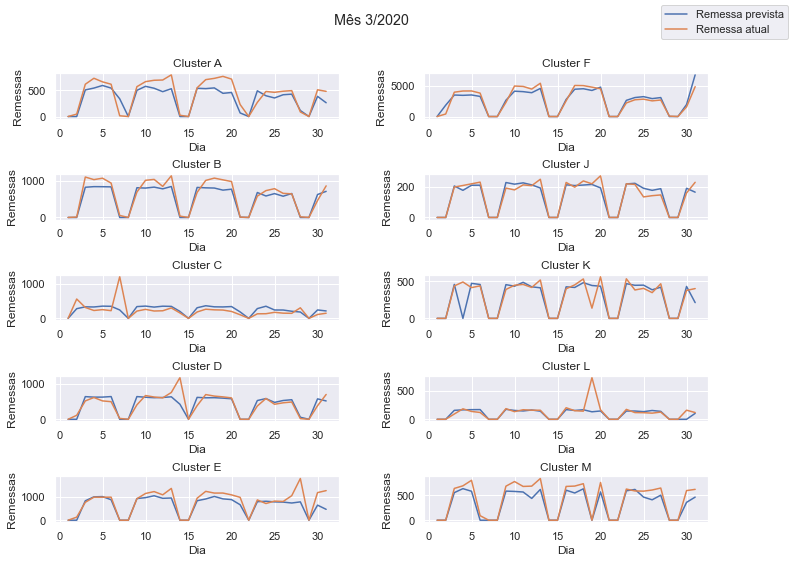

In [62]:
gerarGraficoMensalClusterEspecifico(X_treino, X_teste, y_teste, resultadoZIRPoisson, comecoMes = 0)

Uma melhora considerável em relação ao gráfico da Distribuição de Poisson padrão. Agora, as métricas.

In [63]:
gerarMetricaGeral(y_teste, resultadoZIRPoisson)

Mean Squared Error: 61741.0600951441
Root Mean Squared Error: 248.47748408084001
Mean Absolute Error: 127.08034041744041



In [64]:
gerarMetricasClusters(X_teste, y_teste, resultadoZIRPoisson)

No Cluster A
Mean Squared Error: 22781.87630402639
Root Mean Squared Error: 150.93666322012817
Mean Absolute Error: 116.67804092902433

No Cluster B
Mean Squared Error: 23448.355454264114
Root Mean Squared Error: 153.12855858481825
Mean Absolute Error: 118.66851835903226

No Cluster C
Mean Squared Error: 41760.06306483548
Root Mean Squared Error: 204.35279069500245
Mean Absolute Error: 118.74762575124656

No Cluster D
Mean Squared Error: 28222.82480667304
Root Mean Squared Error: 167.99650236440354
Mean Absolute Error: 93.42230460874893

No Cluster E
Mean Squared Error: 84026.47057938714
Root Mean Squared Error: 289.8731974146405
Mean Absolute Error: 175.18196970273564

No Cluster F
Mean Squared Error: 374414.2952178746
Root Mean Squared Error: 611.8940228649685
Mean Absolute Error: 440.61638041142163

No Cluster J
Mean Squared Error: 857.5370527848878
Root Mean Squared Error: 29.283733586837723
Mean Absolute Error: 19.068237290142612

No Cluster K
Mean Squared Error: 13885.14041841485

Valores definitivamente melhores que a distribuição normal. Valores variando por volta dos 18 até 120, com um erro maior nos *clusters* E e F. Apesar do *cluster* L ter um pico entre os dias 15 e 20 que o modelo não previu, ele se manteve estável no resto do mês, fazendo sua média de erro absolto ser um valor baixo. Por isso a importância de avaliar tanto os gráficos quanto as métricas.

In [65]:
gerarExcel(resultadoZIRPoisson, X_teste, mes = mes, ano = ano, nome = 'ZIR_Poisson', train = True)

## Conclusão

Os algoritmos que se saíram melhor nesse case foram ambas as implementações de *Random Forest*. Os modelos previram valores 0 corretamente e chegaram muito próximos do valor real do mês analisado do conjunto de dados. Os modelos que se saíram relativamente bem foram as implementações da Distribuição de Poisson, com destaque à versão inflada por zeros. Já a regressão linear não se saiu bem, possivelmente tendo causa a quantidade de 0 que existe no modelo, atrapalhando na hora da sua predição. 

## Modelos preditivos para o conjunto de dados "Plano de Volume"

Agora, os modelos serão treinados com o dataset "Plano de Volume" e, então, gerar um arquivo em Excel com os resultados.

In [66]:
X_treino, X_teste, y_treino = gerarDados(trainTestSplit = True)

### *Random Forest* convencional

In [67]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultadoRF)

In [68]:
gerarExcel(resultadoRF, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_RandomForest')

### *Random Forest* com Zero-Inflated Regressor

In [69]:
resultado_RF_ZIR = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultado_RF_ZIR)

In [70]:
gerarExcel(resultado_RF_ZIR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_ZIR_RandomForest')

### Regressão Linear

In [71]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Assimetria: 2.673617616434807
Curtose: 7.110120848654178


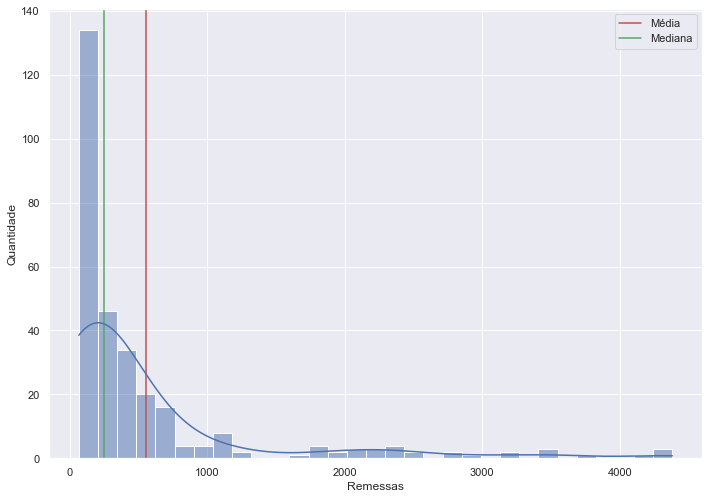

In [77]:
gerarHistograma(resultadoLR)

In [72]:
gerarExcel(resultadoLR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Linear_Regression')

### Regressão Linear com *Zero-inflated regressor*

In [ ]:
resultado_ZIR_LR = gerarResultadoZIR_LR(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


Assimetria: 2.673617616434807
Curtose: 7.110120848654178


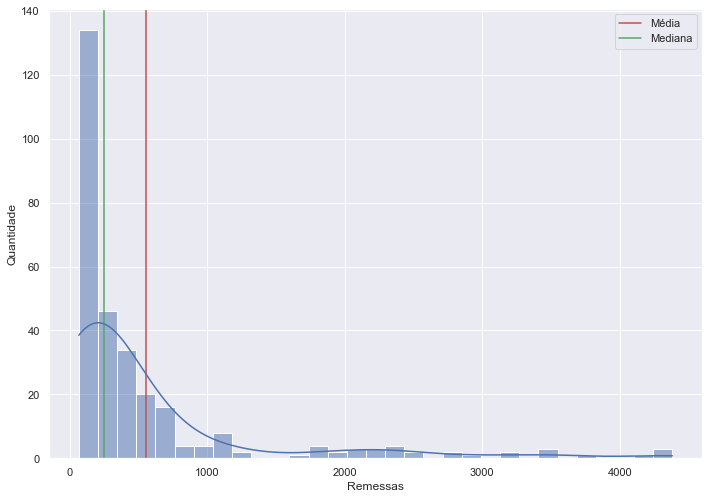

In [ ]:
gerarHistograma(resultado_ZIR_LR)

In [ ]:
gerarExcel(resultado_ZIR_LR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_ZIR_Linear_Regression')

### Distribuição de Poisson

In [73]:
resultadoPoisson = gerarResultadoPoisson(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultadoPoisson)

In [74]:
gerarExcel(resultadoPoisson, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Poisson')

### Distribuição de Poisson com *Zero-Inflated Regressor*

In [75]:
resultado_Poisson_ZIR = gerarResultadoZIRPoisson(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultado_Poisson_ZIR)

In [76]:
gerarExcel(resultado_Poisson_ZIR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Poisson_ZIR')